# Class 20: Linear Regression

CBE 20258. Numerical and Statistical Analysis. Spring 2020.

&#169; University of Notre Dame

In [1]:
# load libraries
import scipy.stats as stats
import numpy as np
import math
import matplotlib.pyplot as plt

## Class 20 Learning Objectives

After studying this notebook and your lecture notes, you should be able to:
* Interpret correlation coefficient
* Compute simple linear regression best fits
* Check linear regression error assumptions using residual analysis (plots)
* Compute residual standard error and covariance matrix for fitted parameters
* Assemble confidence intervals for fitted parameters

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Review Chapter 7 in Navidi (2015). Then complete the handout C20-class-activities.pdf on Sakai and upload to Gradescope.
</div>

## 20a. Correlation

**Further Reading:** §7.1 in Navidi (2015)

## 20b. The Best Fit Line

Further Reading: §7.2 in Navidi (2015)

### Motivating Example for Linear Regression

What job responsibilities do you think a chemical engineer would have in the agriculture industry?

A fellow scientist in Big Ag, Inc. planted alfalfa on several plots of land, identical except for the soil pH. The following are the dry matter yields (in pounds per acre) for each plot.

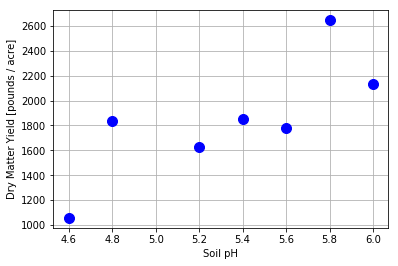

In [2]:
pH = np.array([4.6, 4.8, 5.2, 5.4, 5.6, 5.8, 6.0])
yld = np.array([1056, 1833, 1629, 1852, 1783, 2647, 2131])

plt.plot(pH,yld,'b.',MarkerSize=20)
plt.xlabel('Soil pH')
plt.ylabel('Dry Matter Yield [pounds / acre]')
plt.grid(True)
plt.show()

Your colleague would like help analyzing these data. In particular:
1. Is the trend in the data linear?
2. Can we create a model to predict the dry matter yield based on soil pH?
3. How can we incorporate uncertainty into our model?

We will use this example throughout the lecture to introduce the fundamentals of linear regression.

### Linear Regression Basics

Based on the plot above, your colleague suggests a simple linear model:

$$y = \beta_0 + \beta_1 x + \epsilon$$

Nomenclature:
* $y$ is the yield (dependent variable, response, observed variable)
* $x$ is the pH (independent variable, feature, manipulated variable)
* $\beta_0$ is the intercept
* $\beta_1$ is the slope
* $\epsilon$ is the random observation error. More on it latter.

We cannot measure $\beta_0$ and $\beta_1$ directly. Instead, we can take paired measurements ($x_1, y_1$), ($x_2, y_2$),... ($x_n, y_n$) and find the values of $\hat{\beta}_0$ and $\hat{\beta}_1$ that cause the predictions $\hat{y}$ to best fit the data.

$$\hat{y} = \hat{\beta}_0 + \hat{\beta}_1 x$$

Nomenclature:
* $\hat{y}$ **predicted** response
* $\hat{\beta}_0$ **best fit** intercept, estimates true (unknown) intercept
* $\hat{\beta}_1$ **best fit** slope, estimates true (unknown) intercept

**Main idea**: $\hat{\beta}_0$ and $\hat{\beta}_1$ are **estimates** of the true (but unknown) intercept and slope.

### Optimization Formulation

At the heart of regression, we want to solve a least-squares minimization problem:

$$\min_{\hat{\beta}_0,\hat{\beta}_1} \quad \sum_{i}^n(y_i - \hat{y}_i)^2$$

We have done this in multiple lectures already.

### Analytic Solution

Because our model is linear, it is not that difficult to find the analytic solution to the above optimization problem.

$$\hat{\beta}_1 = \frac{\sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^{n} (x_i - \bar{x})^2}$$

$$\hat{\beta}_0 = \bar{y} - \hat{\beta}_1 \bar{x}$$

Here $\bar{x}$ and $\bar{y}$ are the average (mean) values of the independent and dependent variables, respectively, calculated using the sample.

$$
\bar{y} = \frac{1}{n} \sum_{i=1}^n y_i, \qquad \bar{x} = \frac{1}{n} \sum_{i=1}^n x_i
$$

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Discuss the following with your neighbor:
</div>

1. How can you calculate the numerator and denominator in a single line using linear algebra?
2. True/False. The best fit line always passes through ($\bar{x},\bar{y}$). Write a sentence to justify your answer.

In [3]:
x = pH
y = yld
n_farm = len(x)

# calculate averages
xbar = np.mean(x)
ybar = np.mean(y)

# calculate numerator
# num = # fill in
num = (x - xbar).dot(y - ybar)

# calculate denominator
# denom = # fill in
denom = (x - xbar).dot(x-xbar)

# calculate slope
b1 = num / denom

# calculate intercept
b0 = ybar - b1 * xbar

# print results
print("slope = ",b1,"pounds per acre / pH unit")
print("intercept =",b0,"pounds per acre")

slope =  737.1014492753623 pounds per acre / pH unit
intercept = -2090.9420289855075 pounds per acre


### Scipy Package

We can do the same calculations with Scipy.

In [4]:
b1_, b0_, r_value, p_value, std_err = stats.linregress(x, y)

print("slope = ",b1_,"pounds per acre / pH unit")
print("intercept =",b0_,"pounds per acre")

slope =  737.1014492753623 pounds per acre / pH unit
intercept = -2090.9420289855075 pounds per acre


### Visualize

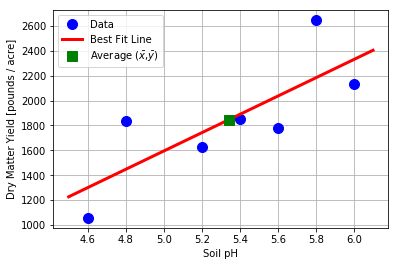

In [5]:
# generate predictions
pH_pred = np.linspace(4.5, 6.1, 20)
yld_pred = b0_ + b1_ * pH_pred

# create plot
plt.plot(pH,yld,'.b',MarkerSize=20,label='Data')
plt.plot(pH_pred,yld_pred,'-r',LineWidth=3,label='Best Fit Line')
plt.plot(xbar,ybar,'sg',MarkerSize=10,label=r"Average ($\bar{x}$,$\bar{y}$)")
plt.xlabel('Soil pH')
plt.ylabel('Dry Matter Yield [pounds / acre]')
plt.grid(True)
plt.legend()
plt.show()

## 20c. Residual Analysis

**Further Reading:** §7.4 in Navidi (2015), *Checking Assumptions and Transforming Data*

Recall the simple linear model:

$$y_i = \beta_0 + \beta_1 x_i + \epsilon_i$$

We are now going to focus on the random observation error $\epsilon$. In order to perform **uncertainty analysis and statistical inference** (next notebook section), we need to check the following **assumptions about the error**:
1. The errors $\epsilon_1$, ..., $\epsilon_n$ are **random and independent**. Thus the magnitude of any error $\epsilon_i$ does not impact the magnitude of error $\epsilon_{i+1}$.
2. The errors $\epsilon_1$, ..., $\epsilon_n$ all have **mean zero**.
3. The errors $\epsilon_1$, ..., $\epsilon_n$ all have the **same variance**, denoted $\sigma^2$.
4. The errors $\epsilon_1$, ..., $\epsilon_n$ are **normally distributed**.

We will now discuss several strategies to check these assumptions.

### Calculate Residuals

We cannot measure $\epsilon_i$ directly. Instead, we will estimate it using the residual:

$$
\underbrace{e_i}_{\mathrm{residual}} = \underbrace{y_i}_\mathrm{observation} - \underbrace{\hat{y}_i}_{\mathrm{prediction}}
$$

We might write $r_i$ instead of $e_i$ for residual. Old habit.

In [6]:
yld_hat = b0_ + b1_ * pH
e_farm = yld - yld_hat
print("Residuals (pounds / acre):")
print(e_farm)

Residuals (pounds / acre):
[-243.72463768  385.85507246 -112.98550725  -37.4057971  -253.82608696
  462.75362319 -200.66666667]


### Histogram of Residuals

Assumption 4: Are the residuals normally distributed?

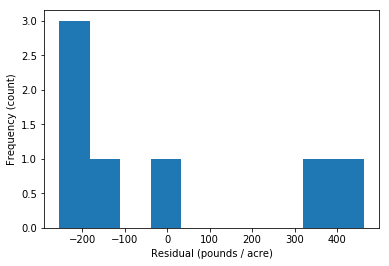

In [7]:
plt.hist(e_farm)
plt.xlabel("Residual (pounds / acre)")
plt.ylabel("Frequency (count)")
plt.show()

**Interpretation Questions:**
1. Are there any extreme outliers?
2. (large data sets) Does the histogram look approximately normal?

### Scatter Plot of Residuals versus Predicted Values

Assumption 1: Are the residuals random and independent?

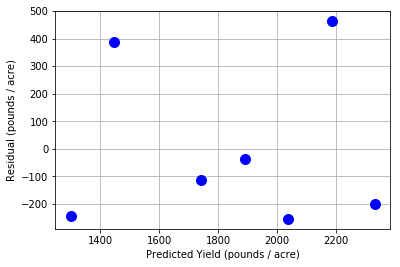

In [8]:
plt.plot(yld_hat,e_farm,"b.",MarkerSize=20)
plt.xlabel("Predicted Yield (pounds / acre)")
plt.ylabel("Residual (pounds / acre)")
plt.grid(True)
plt.show()

**Interpretation Questions**:
1. Are there any clear patters in the residuals?
2. Are there any extreme outliers?

**Additional Examples**

![](https://drive.google.com/uc?export=view&id=18C0Lsiy5xXUWXGZ3shsKsv3CnsjufU-n)

### Scatter Plot of Residuals versus Independent Variable

Assumption 1: Are the residuals random and independent?

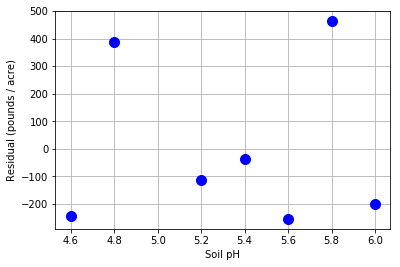

In [9]:
plt.plot(pH,e_farm,"b.",MarkerSize=20)
plt.xlabel("Soil pH")
plt.ylabel("Residual (pounds / acre)")
plt.grid(True)
plt.show()

**Interpretation Questions**:
1. Are there any clear patters in the residuals?
2. Are there any extreme outliers?

**Additional Examples**

![](https://drive.google.com/uc?export=view&id=1BobcdQP4SWK4kEeEcvWUAxTK9P_QDsic)


### Scatter Plot of Residuals versus Data Collection Order

If you know the order data were collected, it is critical to create another scatter plot. You need to ensure there are no patterns (correlations) in time.

### Scatter Plot of Residuals Squared versus Independent Variable (and Collection Order)

Assumption 3: Do the residuals have the same variance?

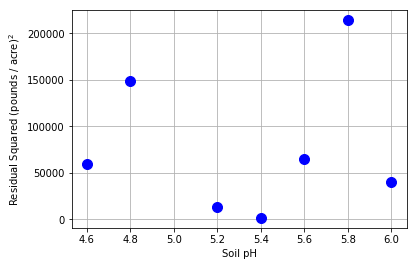

In [10]:
plt.plot(pH,e_farm**2,"b.",MarkerSize=20)
plt.xlabel("Soil pH")
plt.ylabel("Residual Squared (pounds / acre)$^2$")
plt.grid(True)
plt.show()

**Interpretation Questions**:
1. Do the residuals squared grow or shrink as the independent variable increases?
1. Do the residuals squared grow or shrink with collection order?

**Additional Examples**

![](https://drive.google.com/uc?export=view&id=15--jigLRrNUq6TBzIraahIfzpvsJaZfN)

![](https://drive.google.com/uc?export=view&id=1Hu6PEXeZqkUJ2w6mcdXNk6oqXH6k1HL5)

![](https://drive.google.com/uc?export=view&id=1SJzBRLdtv1oqmhLhfZsYsSlLH17_-5GI)


### What if an assumption is violated?

There are several strategies to try:
1. Try a different model (tranform variables, nonlinear regression)
2. Weighted regression
3. Robust regression

We will discuss 1 and 2 during the next few lectures.

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: As an intern, you help run a chemical process 24 times to determine the effect of temperature on yield. The data below are presented in the order of the runs. With a partner, complete the following analysis steps.
</div>

In [11]:
temp = np.array([30, 32, 35, 39, 31, 27, 33, 34, 25, 38, 39, 30, 30, 39, 40, 44, 34, 43, 34, 41, 36, 37, 42, 28])
proc_yld = np.array([49.2, 55.3, 53.4, 59.9, 51.4, 52.1, 60.2, 60.5, 59.3, 64.5, 68.2, 53.0, 58.3,
                     64.3, 71.6, 73.0, 65.9, 75.2, 69.5, 80.8, 78.6, 77.2, 80.3, 69.5])

With a partner, complete the following analysis steps.

#### Plot and Best Fit

Compute the least-squares best fit to predict yield based on process temperature. Show the best fit line overlaid on a scatter plot of the data.

In [12]:
# INSTRUCTIONS: The commented out code below has been copied 
# from the farm example. Modify it to use with the new data set.

## fit coefficients 
# b1_, b0_, r_value, p_value, std_err = stats.linregress(x, y)
# print("slope = ",b1_,"pounds per acre / pH unit")
# print("intercept =",b0_,"pounds per acre")


## generate predictions
# pH_pred = np.linspace(4.5, 6.1, 20)
# yld_pred = b0_ + b1_ * pH_pred


## create plot
# plt.plot(pH,yld,'.b',MarkerSize=20,label='Data')
# plt.plot(pH_pred,yld_pred,'-r',LineWidth=3,label='Best Fit Line')
# plt.xlabel('Soil pH')
# plt.ylabel('Dry Matter Yield [pounds / acre]')
# plt.grid(True)
# plt.legend()
# plt.show()

#### Reisdual Analysis: Part 1

Plot the residuals versus the fitted values. Does the linear model seem appropriate? Write a sentence to explain.

In [13]:
# INSTRUCTIONS: The commented out code below has been copied 
# from the farm example. Modify it to use with the new data set.

## calculate residuals
# yld_hat = b0_ + b1_ * pH
# e_farm = yld - yld_hat
# print("Residuals (pounds / acre):")
# print(e_farm)


## create plot
# plt.plot(yld_hat,e_farm,"b.",MarkerSize=20)
# plt.xlabel("Predicted Yield (pounds / acre)")
# plt.ylabel("Residual (pounds / acre)")
# plt.grid(True)
# plt.show()

#### Residual Analysis: Part 2

Plot the residuals versus the data collection order. Is there a trend in the residuals with time? Does the linear model seem appropriate?

In [14]:
## create plot